In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
fraud_data =pd.read_csv("../data/raw/Fraud_Data.csv")

In [3]:
ip_data= pd.read_csv("../data/raw/IpAddress_to_Country.csv")

In [4]:
credit_data=pd.read_csv("../data/raw/creditcard.csv")

In [5]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [6]:
ip_data.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [8]:
print("Data Types of fraud Data\n\n" ,fraud_data.dtypes)
print("Data Types of Ip Data\n\n" ,ip_data.dtypes)
print("Data Types of credit Data\n\n" ,credit_data.dtypes)

Data Types of fraud Data

 user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object
Data Types of Ip Data

 lower_bound_ip_address    float64
upper_bound_ip_address      int64
country                    object
dtype: object
Data Types of credit Data

 Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V

In [37]:
print("-----------------------Null value count fro fraud data\n\n",fraud_data.isnull().sum())

print("++++++++++++++++++++++++++++Null value count for ip data\n\n",ip_data.isnull().sum())

print("_____________________Null value count for credit data\n\n",credit_data.isnull().sum())

-----------------------Null value count fro fraud data

 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
++++++++++++++++++++++++++++Null value count for ip data

 lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64
_____________________Null value count for credit data

 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [52]:
processed_Fraud_data = pd.read_csv("../data/processed/processed_Fraud_Data.csv", low_memory=False)

In [56]:
processed_Fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,22058.0,2015-02-24 22:55:49,2015-04-18 02:47:11,-0.160204,QVPSPJUOCKZAR,SEO,Chrome,M,39.0,7.327584e+08,...,False,False,False,False,False,False,False,False,False,False
1,333320.0,2015-06-07 20:39:50,2015-06-08 01:38:54,-1.142592,EOGFQPIZPYXFZ,Ads,Chrome,F,53.0,3.503114e+08,...,True,False,False,False,False,False,False,False,False,False
2,1359.0,2015-01-01 18:52:44,2015-01-01 18:52:45,-1.197169,YSSKYOSJHPPLJ,SEO,Opera,M,53.0,2.621474e+09,...,True,False,False,False,False,False,False,False,False,False
3,150084.0,2015-04-28 21:13:25,2015-05-04 13:54:50,0.385567,ATGTXKYKUDUQN,SEO,Safari,M,41.0,3.840542e+09,...,False,False,False,False,False,False,False,False,False,False
4,221365.0,2015-07-21 07:09:52,2015-09-09 18:40:53,0.112681,NAUITBZFJKHWW,Ads,Safari,M,45.0,4.155831e+08,...,True,False,False,False,False,False,False,False,False,False


In [20]:
# Remove duplicates
fraud_data.drop_duplicates(inplace=True)
credit_data.drop_duplicates(inplace=True)

# Correct data types if necessary
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])


In [28]:
fraud_data.head(10)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0
7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0


In [41]:
ip_data.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [17]:
print(fraud_data['purchase_value'].dtype)


int64


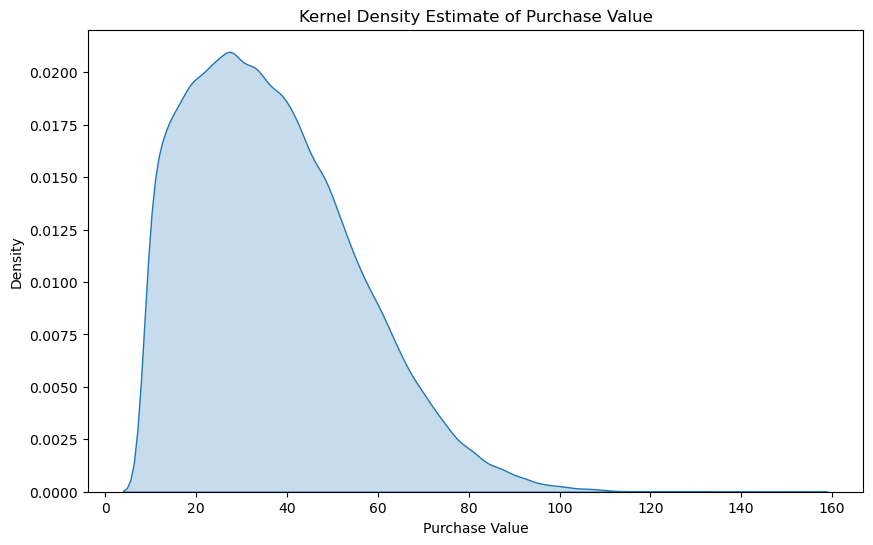

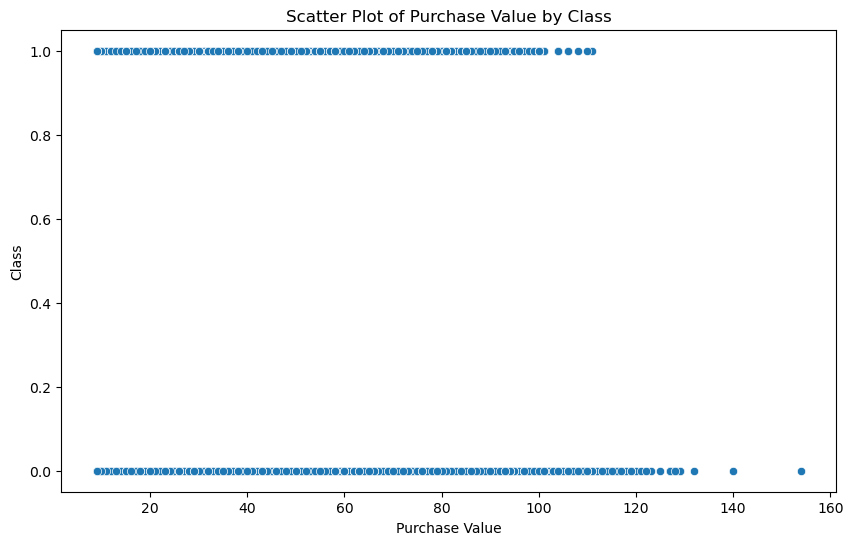

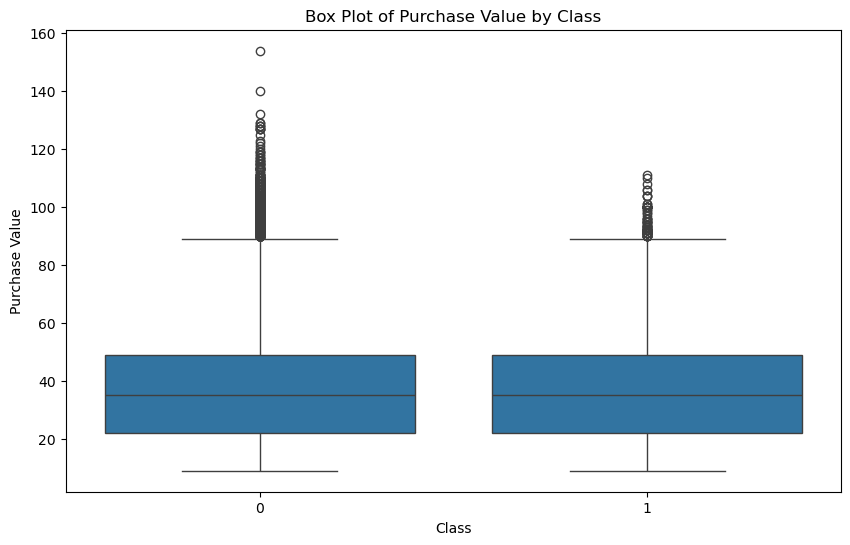

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Univariate analysis - KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=fraud_data, x='purchase_value', fill=True)
plt.title('Kernel Density Estimate of Purchase Value')
plt.xlabel('Purchase Value')
plt.ylabel('Density')
plt.show()

# Bivariate analysis - Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=fraud_data, x='purchase_value', y='class')
plt.title('Scatter Plot of Purchase Value by Class')
plt.xlabel('Purchase Value')
plt.ylabel('Class')
plt.show()

# Bivariate analysis - Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=fraud_data, x='class', y='purchase_value')
plt.title('Box Plot of Purchase Value by Class')
plt.xlabel('Class')
plt.ylabel('Purchase Value')
plt.show()